First we import necessary libraries, download the data, create dataloaders and a mapping function from numerical labels to the clothing labels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = FashionMNIST(download = True, root = "", transform = transform, train = True )
val_set = FashionMNIST(download = True, root = "", transform = transform, train = False )

train_loader = DataLoader(train_set, batch_size = 32)
val_loader = DataLoader(val_set, batch_size = 32)

In [3]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

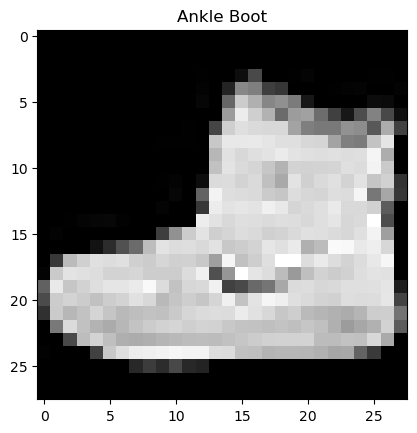

In [4]:
#visualize an example from the training set
x, y = next(iter(train_set))
plt.imshow(x.squeeze(), cmap = "gray")
plt.title(output_label(y));

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff1 = nn.Linear(28*28, 400)
        self.ffmu = nn.Linear(400, 20)
        self.fflogvar = nn.Linear(400, 20)
        self.ff3 = nn.Linear(20, 400)
        self.ff4 = nn.Linear(400, 28*28)

    def encode(self, x):
        x = F.relu(self.ff1(x.view(-1,28*28)))
        mu = self.ffmu(x)
        logvar = self.fflogvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return std*eps + mu
        
    def decode(self, mu, logvar):
        x = self.reparameterize(mu, logvar)
        x = F.relu(self.ff3(x))
        return torch.sigmoid(self.ff4(x))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.decode(mu, logvar)
        return z, mu, logvar


### The loss function for the VAE
An important point, I found out while experimenting with this VAE, is that the training results are highly dependant on the loss function, which is given by
$\text{Loss} = \text{KLD} + \text{BCE} $. 

In particular, since inputs are fed to the model in batches, the BCE loss function performs a reduction on all the datapoints of the batch. This can be chosen to either be the sum or mean of the BCE loss of the inputs of the batch.
Since a the batch size is 32, using the sum-reduction will give a 32 times larger BCE loss than the mean-reduction.
Using the 'mean' reduction results in the BCE term being outweight by the KLD term, resulting in a model with a low capability of reconstructing the input image. Using the 'sum' reduction gives good results.

However, there is one problem with using the sum reduction. If the number of samples is not divisible by the batch size, then the final batch will not contain 32 datapoints, therefore leading to a lower bce loss.
To mitigate both discussed problems, we take the mean reduction but multiply the bce loss by a factor of 32.

In [6]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

def kld_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

bce_loss = nn.BCELoss(reduction= "sum")
mse_loss = nn.MSELoss(reduction = "mean")

Next we define a training and evaluation function function for the model and record the BCE, KLD and MSE losses for the last batch of each epoch in a dictionary.

In [7]:
def train_step(model, dataloader):
    model.train()
    for x,y in train_loader:
        optimizer.zero_grad()
        x_pred, mu, logvar = model(x)
        x = x.view(-1, 28*28)
        KLD = kld_loss(mu, logvar)
        BCE = bce_loss(x_pred, x)
        MSE = mse_loss(x_pred, x)
        loss = KLD + BCE
        loss.backward()
        optimizer.step()

    return BCE.item(), KLD.item(), MSE.item()

def evaluate(model, dataloader):
    with torch.no_grad():
        model.eval()
        for x,y in dataloader:
            x_pred, mu, logvar = model(x)
            x = x.view(-1, 28*28)
            x_pred = x_pred.view(-1,28*28)
            KLD = 2* kld_loss(mu, logvar)
            BCE = 2* bce_loss(x_pred, x)
            MSE = 2* mse_loss(x_pred, x).detach()

    return BCE.item(), KLD.item(), MSE.item()

def train(model, epochs):
    train_loss = {"BCE" : [], "KLD" : [], "MSE" : []}
    val_loss = {"BCE" : [], "KLD" : [], "MSE" : []}

    for i in range(epochs):
        #training
        bce, kld, mse = train_step(model, train_loader)
        train_loss["BCE"].append(bce)
        train_loss["KLD"].append(kld)
        train_loss["MSE"].append(mse)
        #evaluating
        bce, kld, mse = evaluate(model, val_loader)
        val_loss["BCE"].append(bce)
        val_loss["KLD"].append(kld)
        val_loss["MSE"].append(mse)
    return train_loss, val_loss
    

We check the untrained models output on the same shoe image as before. 
As expected, it looks like random noise.

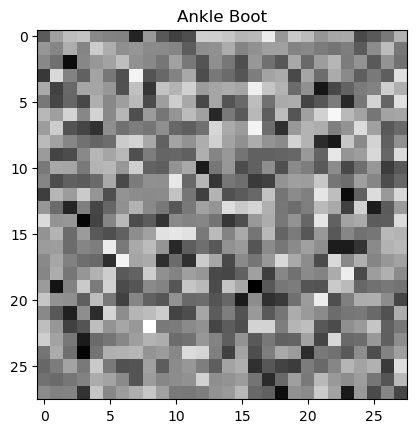

In [8]:
x,y = next(iter(train_set))
img, _, _ = model(x)
img = img.view(1,28,28).permute(1,2,0).detach().numpy() #plt needs the (H,W,C) format
plt.imshow(img, cmap = "gray")
plt.title(output_label(y));

We train the model for 20 epochs

In [9]:
train_loss, val_loss = train(model, 20)

We see that the model is now able to reconstruct the original input quite well, albeit with the loss of some detail, which seems to have been "smoothed out". This is because, before the decoding step, we sample from the learned latent distribution, which is close to a normal distribution.

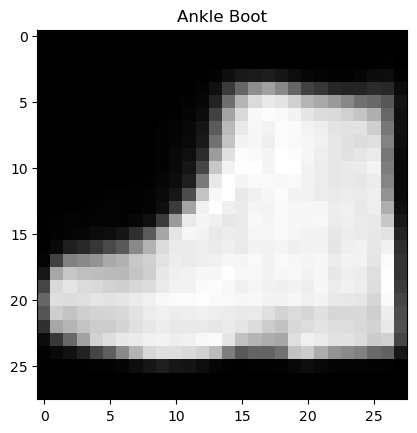

In [10]:
x,y = next(iter(train_set))
img, _, _ = model(x)
img = img.view(1,28,28).permute(1,2,0).detach().numpy()
plt.imshow(img, cmap = "gray")
plt.title(output_label(y));

Finally, we plot the models training and validation BCE, MSE and KLD loss curves. 

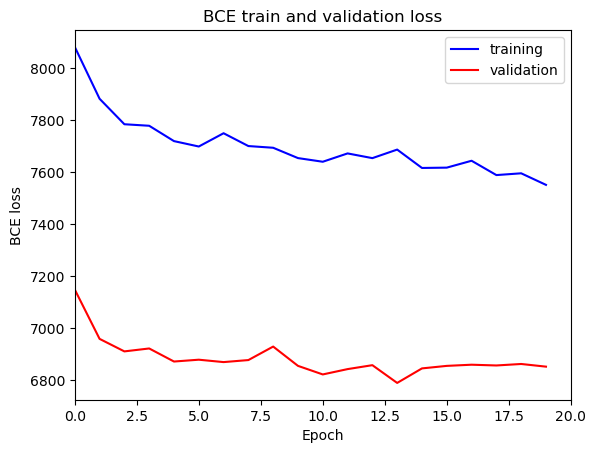

In [11]:
plt.plot(range(20), train_loss["BCE"], "blue", label = "training")
plt.plot(range(20), val_loss["BCE"], "red", label = "validation")
plt.title("BCE train and validation loss")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.xlim(0, 20);
plt.legend();

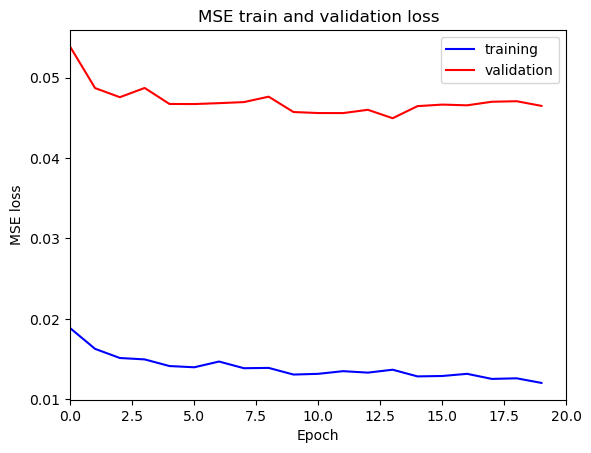

In [12]:
plt.plot(range(20), train_loss["MSE"], "blue", label = "training")
plt.plot(range(20), val_loss["MSE"], "red", label = "validation")
plt.title("MSE train and validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xlim(0, 20);
plt.legend();

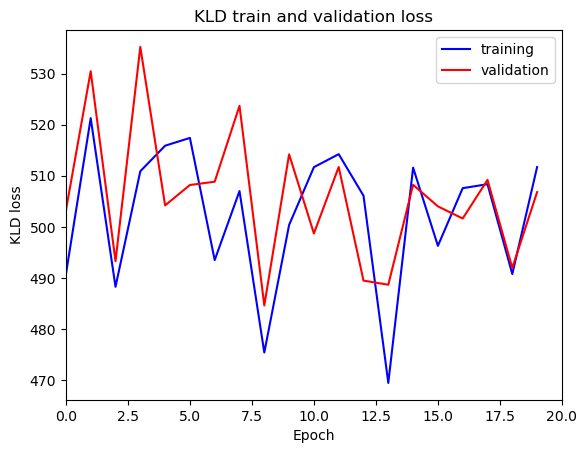

In [13]:
plt.plot(range(20), train_loss["KLD"], "blue", label = "training")
plt.plot(range(20), val_loss["KLD"], "red", label = "validation")
plt.title("KLD train and validation loss")
plt.xlabel("Epoch")
plt.ylabel("KLD loss")
plt.xlim(0, 20);
plt.legend();